This assignment is inspired by: 

- https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression
- https://www.kaggle.com/code/dansbecker/xgboost/notebook

In this assignment we will apply XGBoost Regression techniques to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Step 1 is to download the dataset.

In [1]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas  as pd
import numpy   as np
import xgboost as xgb
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#=========================================================================
# read in the data
#=========================================================================
train_data = pd.read_csv(r'C:\Users\administrateur\BTC-DATA\Exercice.Xcboost\train.csv',index_col=0)
test_data  = pd.read_csv(r'C:\Users\administrateur\BTC-DATA\Exercice.Xcboost\test.csv',index_col=0)

### <center style="background-color:Gainsboro; width:60%;">Feature selection</center>
The purpose of feature selection, as the name suggests, is to only model the most pertinent and important features, thus reducing the computational overhead, and also to alleviate the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). The following are a number of notebooks covering techniques to achieve said goal, all of which use the House Prices data as an example:

* [Feature selection using the Boruta-SHAP package](https://www.kaggle.com/carlmcbrideellis/feature-selection-using-the-boruta-shap-package)
* [Recursive Feature Elimination (RFE) example](https://www.kaggle.com/carlmcbrideellis/recursive-feature-elimination-rfe-example)
* [House Prices: Permutation Importance example](https://www.kaggle.com/carlmcbrideellis/house-prices-permutation-importance-example)
* [Feature importance using the LASSO](https://www.kaggle.com/carlmcbrideellis/feature-importance-using-the-lasso)

In this assignment, we shall use all of the numerical columns, and ignore the categorical features. To encode the categorical features one can use for example [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html). 

Our first task is to do Feature Exploration and Selection. 

In [3]:
corr_matrix = train_data.corr()
print(corr_matrix["SalePrice"].sort_values(ascending=False))

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [23]:
y_train = train_data["SalePrice"]
x_train = train_data.drop("SalePrice", axis=1)

# Do the same for the test set
y_test = test_data["SalePrice"]
x_test = test_data.drop("SalePrice", axis=1)

# Keep only numerical columns, ignoring the categorical ones
x_train = x_train.select_dtypes(include=['number']).copy()
x_test = x_test.select_dtypes(include=['number']).copy()

# Replace NaN values with the mean 
x_train.fillna(x_train.mean(), inplace=True)
x_test.fillna(x_test.mean(), inplace=True)

KeyError: 'SalePrice'

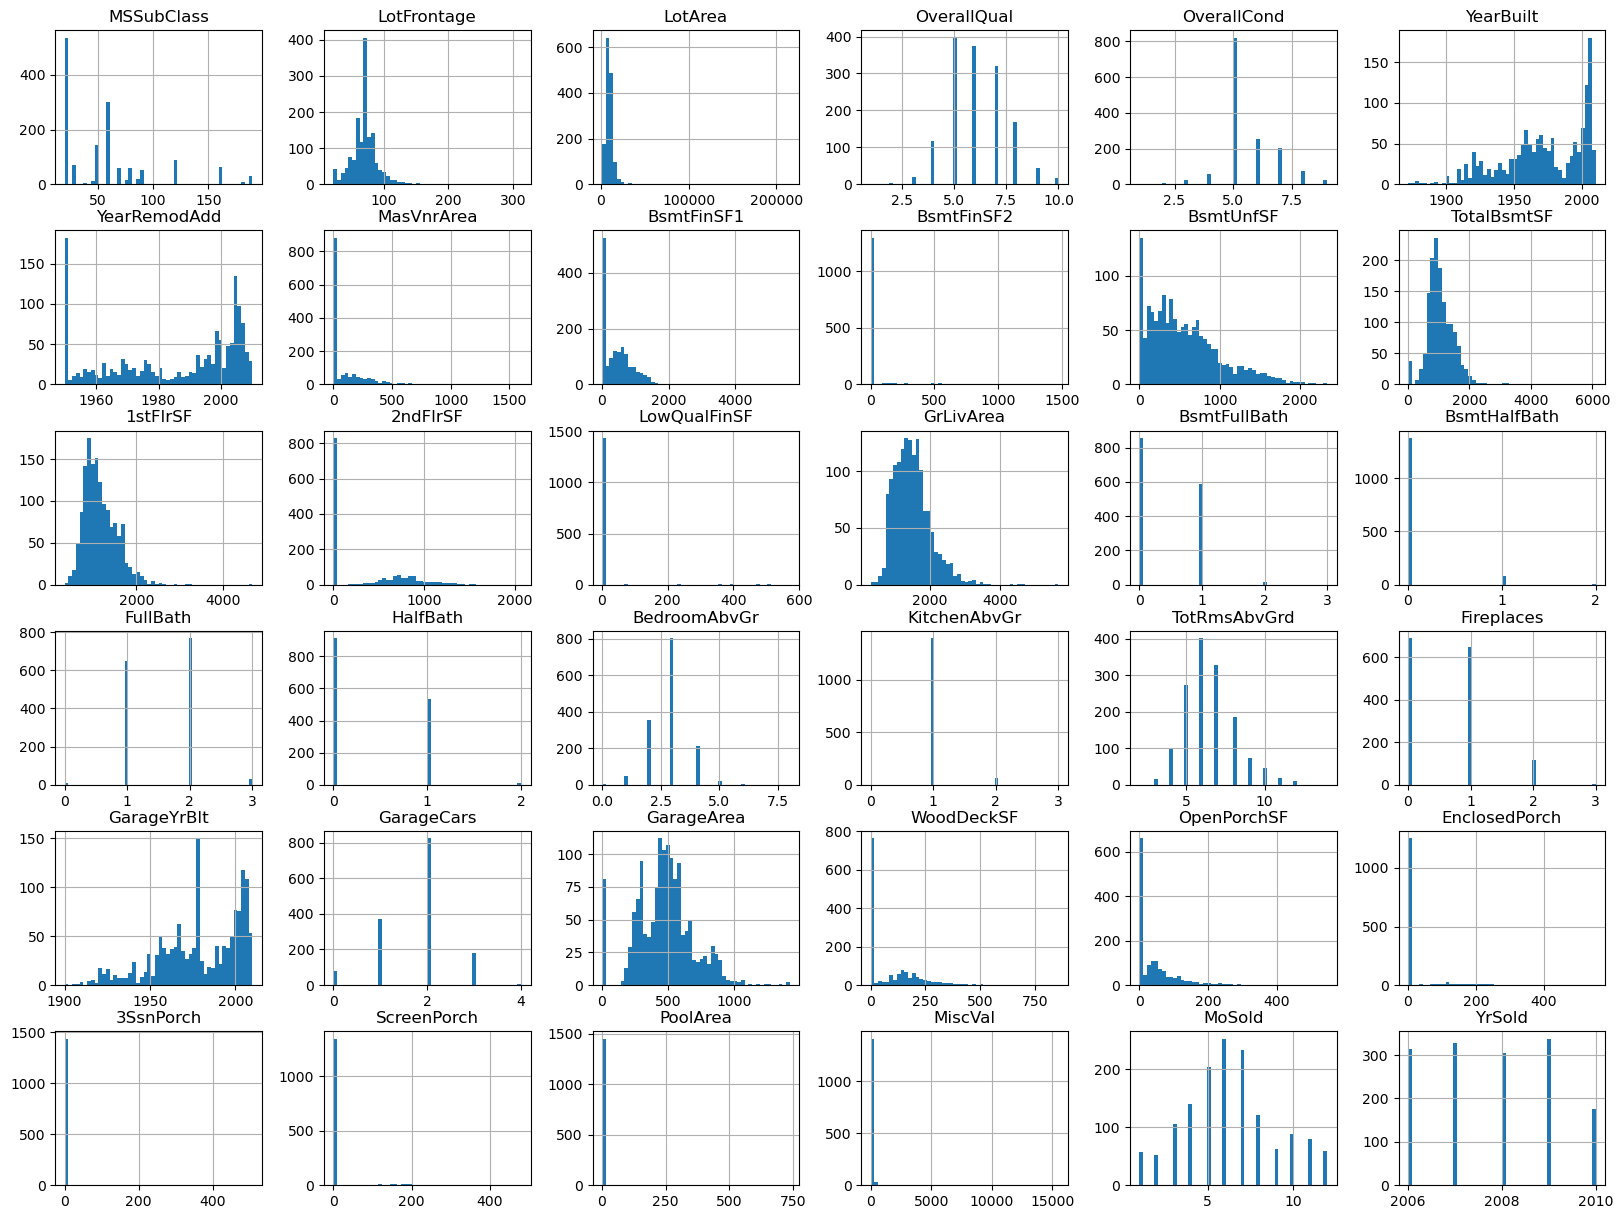

In [5]:
x_train.hist(bins=50, figsize=(20,15))
plt.show()

### <center style="background-color:Gainsboro; width:60%;">Feature engineering</center>
As mentioned, one aspect of feature engineering is the creation of new features out of existing features. A simple example would be to create a new feature which is the sum of the number of bathrooms in the house:

In [8]:
for df in (x_train, x_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"]  = df["GrLivArea"] + df["TotalBsmtSF"]

Your next task is to apply some feature engineering to prepare for using the XGBoost Estimator to predict house prices.

In [9]:
train_data['HouseAge']= train_data['YrSold'] - train_data['YearBuilt']
test_data['HouseAge']= test_data['YrSold'] - test_data['YearBuilt']

In [11]:
# filling the lotfrantage mean
train_data['LotFrontage'].fillna(train_data['LotFrontage'].mean(), inplace=True)

In [12]:
print(train_data.shape)
print(train_data.isnull().sum())

(1460, 80)
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
HouseAge         0
Length: 80, dtype: int64


For more on this fascinating aspect may I recommend the free on-line book ["*Feature Engineering and Selection: A Practical Approach for Predictive Models*"](http://www.feat.engineering/) by Max Kuhn and Kjell Johnson.
### <center style="background-color:Gainsboro; width:60%;">XGBoost estimator</center>
Note that for this competition we use the RMSLE evaluation metric, rather than the default metric, which for regression is the RMSE. For more on the peculiarities of the RMSLE see the Appendix below.

In [13]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

Can you use grid search to find the optimal hyper parameters?

In [15]:
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5)

# Fit the model
grid_search.fit(x_train, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

print(f"Best parameters: {best_parameters}")


Best parameters: {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


In [ ]:
print("The best hyperparameters are ",search.best_params_)

Now, can you setup a XGBoost Regressor object using your hyperparameters and fit it?

In [16]:
# Using the best parameters to train the model
xg_reg_optimal = xgb.XGBRegressor(learning_rate=0.015, max_depth=4, n_estimators=700, eval_metric='rmsle')

# Fit the model
xg_reg_optimal.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.015, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=700, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Finally, can you run it on your test set?

In [30]:

y_pred = xg_reg_optimal.predict(x_test)

In [ ]:
Can you score your solution offline and see how it does?

In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(xg_reg_optimal, x_train, y_train,
                         scoring='neg_root_mean_squared_error', cv=5)
rmse_scores = -scores

print('Scores:', rmse_scores)
print('Mean:', rmse_scores.mean())
print('Standard deviation:', rmse_scores.std())


Scores: [22797.9350111  31353.34608737 29216.87726626 23302.10643053
 29159.19486578]
Mean: 27165.891932206247
Standard deviation: 3456.080317200226


In [34]:
# read in the ground truth file
solution   = pd.read_csv(BTC-DATA/Exercice.Xcboost/XGBoost Regression Assignment (Submit to Kaggle) (2).ipynb)
y_true     = solution["SalePrice"]

from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions) )
print("The score is %.5f" % RMSLE )

SyntaxError: invalid syntax (1769361791.py, line 2)

Finally, use the below block to prepare your submission

In [33]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

NameError: name 'predictions' is not defined

### <center style="background-color:Gainsboro; width:60%;">Feature importance</center>
Let us also take a very quick look at the feature importance too:

NotFittedError: need to call fit or load_model beforehand

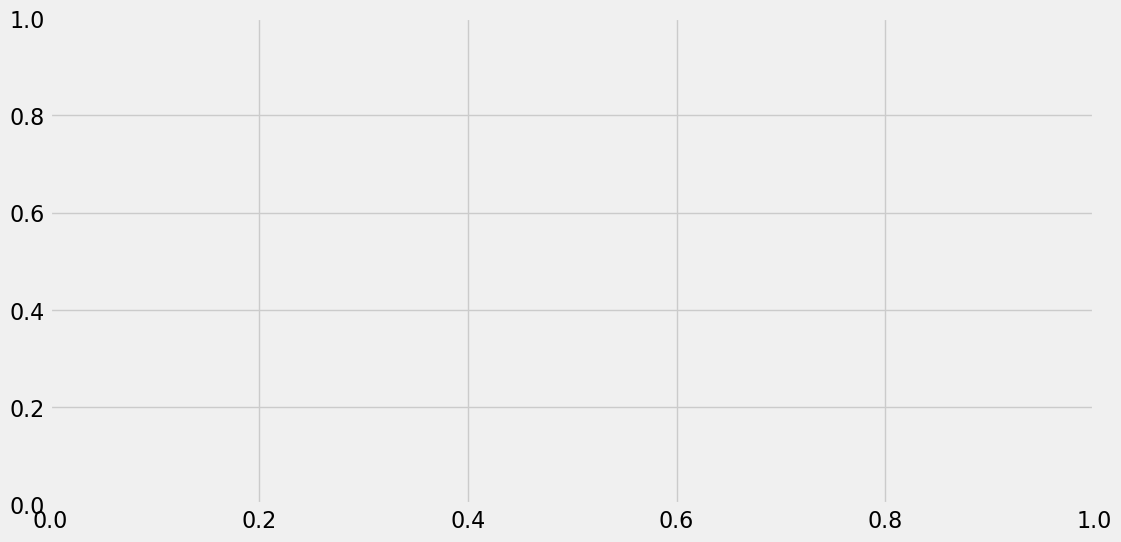

In [37]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

In [1]:
# code here

### <center style="background-color:Gainsboro; width:60%;">Appendix: The RMSLE evaluation metric</center>
From the competition [evaluation page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/evaluation) we see that the metric we are using is the root mean squared logarithmic error (RMSLE), which is given by

$$ {\mathrm {RMSLE}}\,(y, \hat y) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2} $$

where $\hat{y}_i$ is the predicted value of the target for instance $i$, and $y_i$
is the actual value of the target for instance $i$.

It is important to note that, unlike the RMSE, the RMSLE is asymmetric; penalizing much more the underestimated predictions than the overestimated predictions. For example, say the correct value is $y_i = 1000$, then underestimating by 600 is almost twice as bad as overestimating by 600:

In [35]:
def RSLE(y_hat,y):
    return np.sqrt((np.log1p(y_hat) - np.log1p(y))**2)

print("The RMSLE score is %.3f" % RSLE( 400,1000) )
print("The RMSLE score is %.3f" % RSLE(1600,1000) )

The RMSLE score is 0.915
The RMSLE score is 0.470


The asymmetry arises because 

$$ \log (1 + \hat{y}_i) - \log (1 + y_i) =  \log \left( \frac{1 + \hat{y}_i}{1 + y_i} \right) $$

so we are essentially looking at ratios, rather than differences such as is the case of the RMSE. We can see the form that this asymmetry takes in the following plot, again using 1000 as our ground truth value:

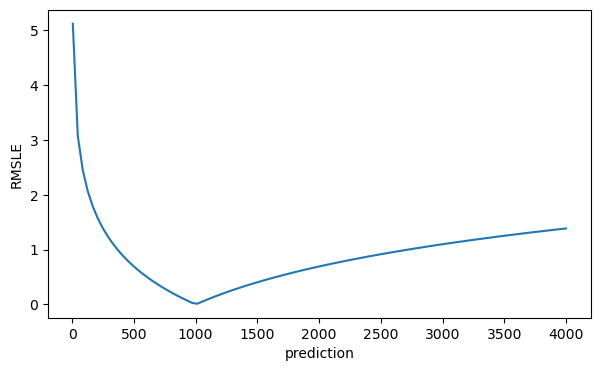

In [36]:
plt.rcParams["figure.figsize"] = (7, 4)
x = np.linspace(5,4000,100)
plt.plot(x, RSLE(x,1000))
plt.xlabel('prediction')
plt.ylabel('RMSLE')
plt.show()